In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '2' # "KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads"

# Import packages

In [3]:
import numpy as np
import xarray as xr
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from cluster_hemi import *
from kwarping_func import *
import matplotlib.ticker as ticker
import warnings
!pip install lmfit
from lmfit import Model


%load_ext autoreload
%autoreload 2
%aimport cluster_hemi
%aimport kwarping_func

# Load data

In [5]:
# Load file first (the data file is not yet an np.array while the angle, energy and time axis will be)
def load_hemi_file(file_path):
    """
    file_path = string of path+file in .itx format
    Loader for Artemis hemi data that has been processed in igor into an .itx file
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    header_line = lines[1]
    dim_info = header_line.split('/N=')[1].split(')')[0]  # Extract the part inside the parentheses
    dims = tuple(map(int, dim_info.strip('()').split(',')))  # Convert to tuple of integers

    k_points, e_points, t_points, _ = dims  # Ignore the last value
    print(f"Number of k-points: {k_points}")
    print(f"Number of e-points: {e_points}")
    print(f"Number of t-points: {t_points}")

    # Skip the first three lines as they are just file information
    data_lines = lines[3:]

    # variables
    data = []
    k_axis = []
    energy_axis = []
    time_axis = []
    current_wave = None
    reading_wave = False
    skip_next_line = False

    for line in data_lines:

        # Skip the line after "END" to not get error
        if skip_next_line:
            skip_next_line = False
            continue

        # Check for key words to get the three axis waves
        if line.startswith("WAVES") and "Data_k" in line:
            current_wave = "k_axis"
            reading_wave = False
            continue
        elif line.startswith("WAVES") and "Data_E" in line:
            current_wave = "energy_axis"
            reading_wave = False
            continue
        elif line.startswith("WAVES") and "Data_t" in line:
            current_wave = "time_axis"
            reading_wave = False
            continue
        elif line.strip() == "END":
            current_wave = None
            skip_next_line = True
            continue
        elif line.strip() == "BEGIN":
            reading_wave = True
            continue

        # Skip lines that start with "X SetScale" or "X Note" yes this is again the same as above but this time it does the trick...
        if line.startswith("X SetScale") or line.startswith("X Note"):
            continue

        # write data into lists
        try:
            if reading_wave:
                if current_wave == "k_axis":
                    k_axis.extend([float(x) for x in line.split()])
                elif current_wave == "energy_axis":
                    energy_axis.extend([float(x) for x in line.split()])
                elif current_wave == "time_axis":
                    time_axis.extend([float(x) for x in line.split()])
            else:
                data.append([float(x) for x in line.split()])
        except ValueError as e:
            print(f"Skipping line due to error: {line}")
            print(e)

    num_scans = None
    for line in lines[lines.index('END\n'):]:
        if "N=" in line:
            num_scans = int(line.split('N=')[1].split(':')[0])
            print(f"I saved {num_scans} scans")
            break
    # Convert lists to numpy arrays
    #data_array = np.array(data)# if you ever have a single scan you can uncomment this but as these are multiple scans it wont work yet and you net to first split the data into the seperate scans
    k_axis = np.array(k_axis)
    energy_axis = np.array(energy_axis)
    time_axis = np.array(time_axis)
    # the last data point is not actually measured so we need to cut it from the data
    le=len(energy_axis)-1
    lk=len(k_axis)-1
    ld=len(data)-1

    energy_axis = energy_axis[:le]
    k_axis = k_axis[:lk]
    data = data[:ld]

    n_scan = t_points
    ldata=len(data)
    num_scans=np.linspace(0,ldata,n_scan+1,dtype=int)
    #split data into tindividual time scans
    scans=[]
    for i,j in enumerate(num_scans[1:]): # add each set of 500 rows together into one scan
        temp_scan = data[j-k_points:j]
        scans.append(temp_scan)

    # -- create list of xarrays
    scansx=[]
    for i,j in enumerate(scans):
        dataTfake= (xr.DataArray(j, dims=("theta_par",'eV'), coords={"theta_par":k_axis,"eV":energy_axis}))
        scansx.append(dataTfake)

    for i, delay in enumerate(time_axis):
        scansx[i].attrs['scan_name']='delay_scan_'+str(delay)+' fs'

    return scans, scansx, time_axis

In [6]:
dataset_name = '58'
datasets = {}

#---def. data path
folder_path = './' ##### folder that contains the dataset file; CHANGE if necessary

#---load data
datasets[dataset_name] = {}
file_path = folder_path + 'Gr_'+ dataset_name + '.itx'
data, datax, t_axis = load_hemi_file(file_path) #This returns a list of all scans: data, and a list of xarrays: datax
datasets[dataset_name]['datax_vs_angle'] = datax
datasets[dataset_name]['t_axis'] = t_axis


Number of k-points: 300
Number of e-points: 480
Number of t-points: 89
I saved 29 scans


# K-warp data

In [8]:
theta_0 = -33 # experimental angular offset
fermienergy = 39.5

datasets[dataset_name]['datax'] = kwarping_scansx(datasets[dataset_name]['datax_vs_angle'], theta_0, fermienergy)

# ROI

In [10]:
k_idx_0 = np.where(datasets[dataset_name]['datax'][0].coords['k_par'].values >= -1.95)[0][0]
k_idx_1 = np.where(datasets[dataset_name]['datax'][0].coords['k_par'].values <= -1.45)[0][-1]
e_idx_0 = np.where(datasets[dataset_name]['datax'][0].coords['eV'].values <= -0.001)[0][-1]
e_idx_1 = np.where(datasets[dataset_name]['datax'][0].coords['eV'].values <= 1.19)[0][-1]
e_idx_1_mdc = np.where(datasets[dataset_name]['datax'][0].coords['eV'].values <= 1.0)[0][-1]


datasets[dataset_name]['roi_dict'] = {
    'roi_k' : (k_idx_0, k_idx_1, int(np.floor((k_idx_1 - k_idx_0)/30))),
    'roi_eall': (e_idx_0-5*8, e_idx_1+5, 5), # range of E-values in figure 1
    'roi_eocc': (e_idx_0, e_idx_1, int(np.floor((e_idx_1 - e_idx_0)/30))), # range of E-values used for clustering
    'roi_emdc': (e_idx_0, e_idx_1_mdc, int(np.floor((e_idx_1_mdc - e_idx_0)/30)))
}

# Save roi_Eb_values
roi_dict = datasets[dataset_name]['roi_dict']
Eb_values = datasets[dataset_name]['datax'][0].coords['eV'].values
datasets[dataset_name]['roi_Eb_values'] = cluster_hemi.save_roi_Eb_values(roi_dict, ['occ', 'all', 'mdc'], Eb_values)

# Save roi_k_values
roi_dict = datasets[dataset_name]['roi_dict']
k_values = datasets[dataset_name]['datax'][0].coords['k_par'].values
datasets[dataset_name]['roi_k_values'] = cluster_hemi.save_roi_k_values(roi_dict, k_values)

# Figure 1


In [13]:
time_idx_1s =26

scansx_1s =datasets[dataset_name]['datax']
t_axis_1s = datasets[dataset_name]['t_axis']
roi_kx_1s = datasets[dataset_name]['roi_dict']['roi_k']
roi_ky_1s = datasets[dataset_name]['roi_dict']['roi_eall']
k_par_roi_1s = datasets[dataset_name]['roi_k_values']
eV_roi_1s = datasets[dataset_name]['roi_Eb_values']['all']


def calculate_ROI_norm_notShift_intensities_1s(scansx, roi_kx, roi_ky, t_axis):
    dimt = len(scansx)  # Number of time points
    dimx, dimy = scansx[0].shape

    data = np.array([scan.values for scan in scansx])
    data = np.nan_to_num(data)  # Remove NaNs

    data = data[:, roi_kx[0]:roi_kx[1], roi_ky[0]:roi_ky[1]]  # Truncate data

    # Prepare for ROI calculation
    num_rois_kx = (roi_kx[1] - roi_kx[0]) // roi_kx[2]
    num_rois_ky = (roi_ky[1] - roi_ky[0]) // roi_ky[2]
    n = roi_kx[2]
    m = roi_ky[2]

    # Calculate integrated intensities
    intensities = np.zeros((num_rois_kx * num_rois_ky, data.shape[0]))
    for idx, image in enumerate(data):
        roi_count = 0
        for roi_x in range(num_rois_kx):
            for roi_y in range(num_rois_ky):
                roi = image[(roi_x)*n:(roi_x+1)*n, (roi_y)*m:(roi_y+1)*m]
                intensities[roi_count, idx] = np.sum(roi)
                roi_count += 1

    # Normalize the intensities, No shift
    norm_notShift_intensities = np.array([trace/np.max(trace) for trace in intensities])
    return norm_notShift_intensities


ROI_norm_notShift_intensities_1s =calculate_ROI_norm_notShift_intensities_1s(scansx_1s, roi_kx_1s, roi_ky_1s, t_axis_1s)
ROI_norm_notShift_intensities_1s_reshaped = ROI_norm_notShift_intensities_1s.reshape(len(k_par_roi_1s), len(eV_roi_1s), len(t_axis_1s))




at t - t0 = 20.0 fs


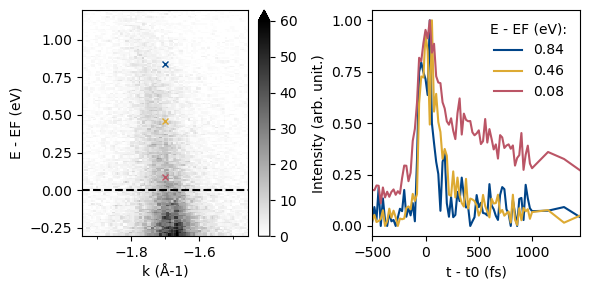

In [14]:
fig, axes = plt.subplots(1,2, figsize=(3*2, 3))

roi_E_idx_s = [8+22, 8+12, 8+2]
roi_k_idx_s = [16, 16, 16]

# plot Photoemission spectrum
ax=axes[0]
with xr.set_options(cmap_sequential='binary'):
    plot_obj = scansx_1s[time_idx_1s].T.plot(ax = ax,vmax=60, add_colorbar=True, rasterized=True)
    ax.axhline(y=0, color='black', linestyle='--', label='Fermi energy')

num_rois_e = (roi_ky_1s[1] - roi_ky_1s[0]) // roi_ky_1s[2]
k_values_raw_1s =  scansx_1s[2].coords['k_par'].values
Eb_values_raw_1s = scansx_1s[2].coords['eV'].values
extent=[k_values_raw_1s[roi_kx_1s[0]], k_values_raw_1s[roi_kx_1s[1] - 1], Eb_values_raw_1s[roi_ky_1s[0]+num_rois_e*roi_ky_1s[2]], Eb_values_raw_1s[roi_ky_1s[0]]]

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[3], extent[2])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.set_xlabel("k (Å-1)")
ax.set_ylabel("E - EF (eV)")

# plot marker positions
ax = axes[0]
for i in range(len(roi_E_idx_s)):
    E_position = eV_roi_1s[roi_E_idx_s[i]]
    k_position = k_par_roi_1s[roi_k_idx_s[i]]
    ax.plot(k_position, E_position, marker='x', markersize=5, color=color_blind_friendly_colors[i])


# plot TDCs
ax = axes[1]

for i in range(len(roi_E_idx_s)):
    roi_E_idx = roi_E_idx_s[i]
    roi_k_idx = roi_k_idx_s[i]
    TDC_cropped = ROI_norm_notShift_intensities_1s_reshaped[roi_k_idx, roi_E_idx,0:-10]
    t_axis_cropped = t_axis_1s[0:-10]
    color = color_blind_friendly_colors[i]
    ax.plot(t_axis_cropped, TDC_cropped,color=color, label = f'{eV_roi_1s[roi_E_idx]:.2f}')

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.legend(title = f'E - EF (eV):', frameon=False)
ax.margins(x=0)
ax.set_xlabel("t - t0 (fs)")
ax.set_ylabel("Intensity (arb. unit.)")

print(f'at t - t0 = {t_axis_1s[time_idx_1s]} fs')
plt.tight_layout()



# Figure 2

In [16]:
# Set clustering parameters
datasets['58']['threshold'] = 8
n_clusters = 6

start = time.time()
datasets[dataset_name]['kmeans_results_wthreshold'] = cluster_hemi.run_kmeans_clustering_with_threshold_gwa(n_clusters, ['occ'], datasets[dataset_name]['roi_dict'], datasets[dataset_name]['datax'], datasets[dataset_name]['threshold'], datasets[dataset_name]['t_axis'])
results = datasets[dataset_name]['kmeans_results_wthreshold']
results[f'resultsocc']['kmeans_norm'], results[f'resultsocc']['kmeans_norm_cluster_centers'], results[f'resultsocc']['kmeans_norm_cluster_mean_energies']= sort_kmeans_clusters_by_mean_energy(results[f'resultsocc']['kmeans_norm'], datasets[dataset_name]['roi_Eb_values'], datasets[dataset_name]['roi_dict'], 'occ')
print(f'Dataset {dataset_name}, Time: {round((time.time() - start)/60,2)} min')

Dataset 58, Time: 1.89 min


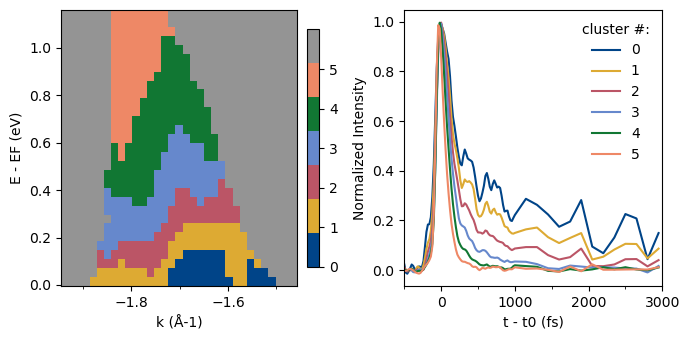

In [17]:
cmap1 = create_custom_cmap(7)
cluster_hemi.plot_clusters_and_centers_norm(datasets[dataset_name]['kmeans_results_wthreshold'], cmap1, 'occ', datasets[dataset_name]['datax'], datasets[dataset_name]['roi_dict'], datasets[dataset_name]['t_axis'])

# Figure 5

In [19]:
def save_mdcs():
    start = time.time()
    #parameters
    name = dataset_name

    # 1. Process dataset (apply gauss), form ROIs and select energy/k-range that will be clustered
    roi_kx = datasets[name]['roi_dict']['roi_k']
    roi_ky = datasets[name]['roi_dict']['roi_emdc']
    num_rois_kx = (roi_kx[1] - roi_kx[0]) // roi_kx[2]
    num_rois_ky = (roi_ky[1] - roi_ky[0]) // roi_ky[2]

    intensities, normalized_intensities = process_dataset_gwa(datasets[name]['datax'], roi_kx, roi_ky, datasets[name]['t_axis'])

    #2. Determine mdcs
    mdc_intensities = np.zeros((num_rois_ky, num_rois_kx, len(datasets[f'{name}']['t_axis'])))

    for energy_idx in range(num_rois_ky):
        mdc_intensities[energy_idx] = intensities[energy_idx::num_rois_ky]


    # Save the results
    mdc_results['t_axis'] = datasets[name]['t_axis']
    mdc_results['roi_k_values'] = datasets[name]['roi_k_values']
    mdc_results['roi_Eb_values'] = datasets[name]['roi_Eb_values']['mdc']
    mdc_results['mdc_intensities'] = mdc_intensities
    mdc_results['mdc_fits'] = {}
    mdc_results['linear_fits'] = {}
    mdc_results['kwarped_datax'] = datasets[name]['datax']

    print(f'processed dataset "{name}" and saved MDCs, Time: {round((time.time() - start)/60,2)} min')

def lorentzMDC(k, k_fwhm, k_peak, I_norm, I_bg):
      """
      Lorentzian function for fitting MDCs.
      Parameters:
      k : Momentum values at which to evaluate the Lorentzian
      k_fwhm : Full width at half maximum (FWHM) of the Lorentzian peak in momentum space
      k_peak : Center position (peak) of the Lorentzian in momentum space
      I_norm : Normalization factor (height/intensity) of the Lorentzian peak
      """

      return I_norm * (k_fwhm/2)/((k - k_peak)**2 + (k_fwhm/2)**2) + I_bg

def lorentzMDC_convolved(k, k_fwhm, k_peak, I_norm, I_bg, sigma_k):
    """ Functtion that convolves the lorentzian function with a Gaussian filter."""

    # Apply Gaussian filter (convolution)
    Lorentzian = lorentzMDC(k, k_fwhm, k_peak, I_norm, I_bg)
    Lorentzian_convolved = gaussian_filter1d(Lorentzian, sigma_k, mode ='nearest')

    return Lorentzian_convolved

lorentzMDC_fit = Model(lorentzMDC_convolved)


def save_mdc_fits_at_tidx(time_index):
    threshold = 6#3 # Only fit MDCs with peak intensity above this threshold

    if 'mdc_intensities' not in mdc_results:
        print("mdc_intensities not found in mdc_results. Run save_mdcs() first.")

    mdc_results['mdc_fits'][f't_idx{time_index}'] = [None] * len(mdc_results['roi_Eb_values']) # array to save the fits

    for energy_idx in range(len(mdc_results['roi_Eb_values'])):
          mdc_intensities_at_Eidx_tidx = mdc_results['mdc_intensities'][energy_idx, :, time_index]

          threshold_reached = np.max(mdc_intensities_at_Eidx_tidx) >= threshold

          if threshold_reached: # Fit the MDC if intensity is above the threshold
              warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0 may give unexpected results.")
              mdc_results['mdc_fits'][f't_idx{time_index}'][energy_idx] = fit_mdc_at_Eidx_tidx(energy_idx, time_index)
          else: # Skip fitting if the intensity at energy_idx and time_index is too low
              print(f"Skipping E_idx {energy_idx}, t_idx {time_index}: below threshold")

    #print(f"Saved fits at t_idx {time_index}")


def fit_mdc_at_Eidx_tidx(energy_idx, time_idx):
    mdc_intensities_at_Eidx_tidx = mdc_results['mdc_intensities'][energy_idx, :, time_idx]

    paramsMDC = lorentzMDC_fit.make_params(
                   k_fwhm = dict(value=0.2, min=0.05, max=0.4,vary=True),
                   k_peak = dict(value=-1.7, min=-1.9, max=-1.5,vary=True),
                   I_norm = dict(value=10, min=0, max=1000,vary=True),
                   I_bg = dict(value=0, min=0, max=2.5, vary=True),
                   sigma_k = dict(value=0.006, vary=False)
                   )

    fit = lorentzMDC_fit.fit(mdc_intensities_at_Eidx_tidx, k=mdc_results['roi_k_values'], params=paramsMDC, method='least_squares')
    '''print(f"Fit parameters at E_idx {energy_idx}, t_idx {time_idx}:")
    for name, p in fit.params.items():
        print(f"{name} = {p.value:.3f} ± {p.stderr:.7f}")'''

    if not fit.success:
        print("Warning: Fit not successful!")

    return fit



In [20]:
def inverted_linear_dispersion(E, v_F, k_0):
    """
    k : Momentum values at which to evaluate the linear dispersion (in 1/A)
    v_F : Fermi velocity (in A/s)
    k_0 : Fermi momentum (in 1/A)

    returns the linear dispersion (in eV)
    """
    hbar = 6.58e-16 #eV*s
    k = - E/ (hbar * v_F) + k_0
    return k


dispersion_fit_inverted = Model(inverted_linear_dispersion)

def save_linear_fit_of_mdc_peaks_withWeights():
    for available_t_idx in [int(key[5:]) for key in mdc_results['mdc_fits'].keys() if key.startswith('t_idx')]:
        available_k_peak_s = []
        available_E_idx_s = []
        weights =[]


        #
        for energy_idx in range(len(mdc_results['roi_Eb_values'])):
            if mdc_results['mdc_fits'][f't_idx{available_t_idx}'][energy_idx] is not None:
                available_k_peak_s.append(mdc_results['mdc_fits'][f't_idx{available_t_idx}'][energy_idx].params['k_peak'].value)
                available_E_idx_s.append(energy_idx)
                k_peak_std = mdc_results['mdc_fits'][f't_idx{available_t_idx}'][energy_idx].params['k_peak'].stderr
                #print(f"t_idx:{available_t_idx}, E_idx={energy_idx}, k_peak_std: {k_peak_std}")
                weights.append(1.0/k_peak_std)

        # fit parameters
        params_dispersion = dispersion_fit_inverted.make_params(
                   v_F = dict(value=1e16, min=0.9e16, max=3.0e16,vary=True),
                   k_0 = dict(value=-1.7, min=-1.75, max=-1.65,vary=True),
                   )
        # Linear fit

        fit = dispersion_fit_inverted.fit(
            available_k_peak_s,
            E=mdc_results['roi_Eb_values'][available_E_idx_s],
            weights=weights,
            params=params_dispersion,
            method='least_squares'
        )
        mdc_results['linear_fits'][f't_idx{available_t_idx}'] = fit
        #print(f"Saved linear fit for t_idx {available_t_idx}")

In [39]:
def plot_vF_vs_time():
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    available_time_indices = [int(key[5:]) for key in mdc_results['linear_fits'].keys() if key.startswith('t_idx')]

    for time in available_time_indices:
        fit = mdc_results['linear_fits'][f't_idx{time}']
        v_F = fit.params['v_F'].value
        v_F_std = fit.params['v_F'].stderr
        hbar = 6.58e-16 #eV*s
        ax.errorbar(mdc_results['t_axis'][time], v_F*(hbar), yerr=v_F_std*(hbar), fmt='x', capsize=3, color='C2')

    ax.set_xlabel(f't-t0 (fs)')
    ax.set_ylabel(f'fitted band slope (eVÅ)')
    ax.set_xlim(-90,135)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))


processed dataset "58" and saved MDCs, Time: 0.87 min


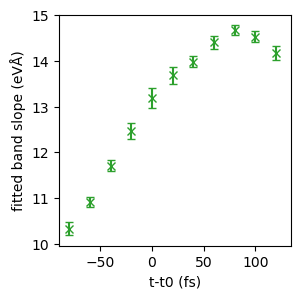

In [41]:
mdc_results = {}
save_mdcs()
for time_idx in range(21, 32): # fitted time range
    save_mdc_fits_at_tidx(time_idx)
save_linear_fit_of_mdc_peaks_withWeights()
plot_vF_vs_time()